In [1]:
!pip install -q optuna optuna-integration[tfkeras]


[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import random
import os

from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras import Model, Input, optimizers
from tensorflow.keras.layers import Conv1D, Dense, Dropout, SpatialDropout1D, LayerNormalization, Activation, Add, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from optuna.integration import TFKerasPruningCallback

In [3]:
file_name = ".SEED.txt"
with open(file_name, "r") as file:
    content = file.read().strip()  # Read and remove any extra whitespace/newlines
    number = int(content)  # Use float() to support decimal; use int() if it's always an integer

print("Seed:", number)
print("Type:", type(number))

Seed: 271828183
Type: <class 'int'>


In [4]:
CSV_PATH   = "ALL_MERGED.csv"   # <--- set your CSV path
DATE_COL   = "Date"
TARGET_COL = "JKSE"
INCLUDE_TARGET_AS_FEATURE = True  # set False to exclude JKSE from X

TEST_SIZE  = 0.20
VAL_SIZE   = 0.10

N_TRIALS   = 50
RANDOM_SEED = number

print(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)

271828183


In [5]:
df = pd.read_csv(CSV_PATH)
required = [
    "Date","Nickel_Fut","Coal_Fut_Newcastle","Palm_Oil_Fut",
    "USD_IDR","CNY_IDR","EUR_IDR","BTC_USD",
    "FTSE100","HANGSENG","NIKKEI225","SNP500","DOW30","SSE_Composite","JKSE"
]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).set_index(DATE_COL)
df = df.ffill().bfill()
df

,Nickel_Fut,Coal_Fut_Newcastle,Palm_Oil_Fut,USD_IDR,CNY_IDR,EUR_IDR,BTC_USD,FTSE100,HANGSENG,NIKKEI225,SNP500,DOW30,SSE_Composite,JKSE
Date,,,,,,,,,,,,,,
2015-05-01,13750.00,62.20,2136,12962.5,2089.78,14519.9,232.078995,6986.000000,28123.82031,19531.63086,2108.290039,18024.06055,4480.463867,5140.937012
2015-05-02,13750.00,62.20,2136,12962.5,2089.78,14519.9,234.929993,6986.000000,28123.82031,19531.63086,2108.290039,18024.06055,4480.463867,5140.937012
2015-05-03,13750.00,62.20,2136,12962.5,2089.78,14519.9,240.358002,6986.000000,28123.82031,19531.63086,2108.290039,18024.06055,4480.463867,5140.937012
2015-05-04,13750.00,62.20,2136,12980.0,2090.51,14467.5,239.018005,6986.000000,28123.82031,19531.63086,2114.489990,18070.40039,4480.463867,5140.937012
2015-05-05,14245.00,62.50,2136,13047.5,2102.39,14594.9,236.121002,6927.600098,27755.53906,19531.63086,2089.459961,17928.19922,4298.706055,5160.107422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-27,15482.88,93.75,4057,16830.0,2309.37,19127.3,93754.843750,8415.299805,21980.74023,35705.73828,5525.209961,40113.50000,3295.060059,6678.915039
2025-04-28,15637.63,95.60,3943,16855.0,2310.59,19251.8,94978.750000,8417.299805,21971.96094,35839.98828,5528.750000,40227.58984,3288.415039,6722.965820
2025-04-29,15564.00,97.25,3911,16760.0,2305.52,19082.1,94284.789060,8463.500000,22008.10938,35839.98828,5560.830078,40527.62109,3286.655029,6749.075195


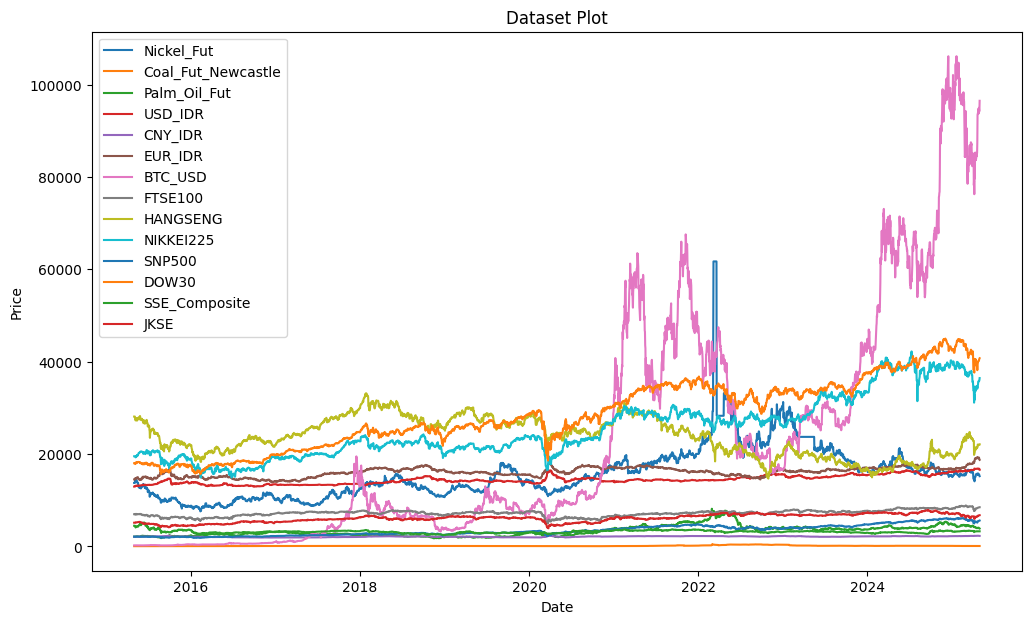

In [6]:
plt.figure(figsize=(12, 7))
plt.plot(df.index, df)
plt.title(f"Dataset Plot")
plt.xlabel("Date"); plt.ylabel("Price")
plt.legend(labels=df.columns)
plt.show()

In [7]:
n = len(df)
test_n = int(np.floor(TEST_SIZE * n))
trainval_n = n - test_n
val_n = int(np.floor(VAL_SIZE * trainval_n))
train_n = trainval_n - val_n

train_df = df.iloc[:train_n].copy()
val_df   = df.iloc[train_n:train_n + val_n].copy()
test_df  = df.iloc[train_n + val_n:].copy()

print(f"Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%) | "
      f"Validation: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%) | "
      f"Test: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

Train: 2632 (72.0%) | Validation: 292 (8.0%) | Test: 730 (20.0%)


In [8]:
if INCLUDE_TARGET_AS_FEATURE:
    feature_cols = df.columns.tolist()          # includes TARGET_COL (JKSE)
else:
    feature_cols = [c for c in df.columns if c != TARGET_COL]

In [9]:
# feature_cols = [c for c in df.columns if c != TARGET_COL]
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaler.fit(train_df[feature_cols])
y_scaler.fit(train_df[[TARGET_COL]])

def scale_block(block):
    X = X_scaler.transform(block[feature_cols])
    y = y_scaler.transform(block[[TARGET_COL]])
    return pd.DataFrame(X, index=block.index, columns=feature_cols), pd.DataFrame(y, index=block.index, columns=[TARGET_COL])

X_train_s, y_train_s = scale_block(train_df)
X_val_s,   y_val_s   = scale_block(val_df)
X_test_s,  y_test_s  = scale_block(test_df)

In [10]:
def make_windows(X_df, y_df, lookback):
    X_vals = X_df.values
    y_vals = y_df.values.squeeze()
    idx = X_df.index

    X_list, y_list, idx_list = [], [], []
    for i in range(lookback, len(X_df)):
        X_list.append(X_vals[i - lookback:i, :])
        y_list.append(y_vals[i])
        idx_list.append(idx[i])

    X_arr = np.array(X_list, dtype=np.float32)
    y_arr = np.array(y_list, dtype=np.float32)
    idx_arr = np.array(idx_list)
    return X_arr, y_arr, idx_arr

In [11]:
def compute_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return [mse, mae, rmse, mape, r2]

In [12]:
def tcn_block(x, filters, kernel_size, dilation_rate, dropout_rate, use_layernorm=True):
    y = Conv1D(filters, kernel_size, padding="causal", dilation_rate=dilation_rate)(x)
    if use_layernorm:
        y = LayerNormalization()(y)
    y = Activation("relu")(y)
    y = SpatialDropout1D(dropout_rate)(y)

    y = Conv1D(filters, kernel_size, padding="causal", dilation_rate=dilation_rate)(y)
    if use_layernorm:
        y = LayerNormalization()(y)
    y = Activation("relu")(y)
    y = SpatialDropout1D(dropout_rate)(y)

    # residual connection (project channels if needed)
    if x.shape[-1] != filters:
        x = Conv1D(filters, 1, padding="same")(x)
    return Add()([x, y])

def build_tcn_model(lookback, n_features, filters, kernel_size, dropout, dilations, num_stacks, lr, use_layernorm=True):
    inp = Input(shape=(lookback, n_features))
    x = inp
    for _ in range(num_stacks):
        for d in dilations:
            x = tcn_block(x, filters, kernel_size, d, dropout, use_layernorm)

    # compress and take last step
    x = Conv1D(1, 1, padding="same")(x)
    x = Lambda(lambda t: t[:, -1, :])(x)  # (batch, 1)
    out = Dense(1)(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss="mse")
    return model

In [ ]:
def objective(trial):
    lookback   = trial.suggest_categorical("lookback", [30, 45, 60, 90])
    filters    = trial.suggest_int("filters", 32, 128, step=32)
    kernel_sz  = trial.suggest_categorical("kernel_size", [3, 5, 7])
    dropout    = trial.suggest_float("dropout", 0.0, 0.5)
    num_stacks = trial.suggest_int("num_stacks", 1, 2)
    dilation_set = trial.suggest_categorical("dilations", [
        (1, 2, 4),
        (1, 2, 4, 8)
    ])
    lr         = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    epochs     = trial.suggest_int("epochs", 30, 100, step=10)
    patience   = trial.suggest_int("patience", 5, 10)

    X_tr, y_tr, _ = make_windows(X_train_s, y_train_s, lookback)
    X_va, y_va, _ = make_windows(X_val_s,   y_val_s,   lookback)

    model = build_tcn_model(
        lookback=lookback,
        n_features=len(feature_cols),
        filters=filters,
        kernel_size=kernel_sz,
        dropout=dropout,
        dilations=list(dilation_set),
        num_stacks=num_stacks,
        lr=lr,
        use_layernorm=True
    )

    callbacks = [
        EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True),
        TFKerasPruningCallback(trial, monitor="val_loss"),
    ]

    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_va, y_va),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=callbacks
    )
    return min(history.history["val_loss"])

In [14]:
sampler = optuna.samplers.TPESampler(seed=RANDOM_SEED)
pruner  = optuna.pruners.MedianPruner(n_startup_trials=15, n_warmup_steps=10)
study = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)

print("\nStarting Optuna study...")
start_opt = time.time()
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)
end_opt = time.time()
print(f"Optuna finished in {end_opt - start_opt:.4f} seconds")
print("Best trial:", study.best_trial.number)
print("Best val_loss:", study.best_value)
print("Best params:", study.best_params)

best = study.best_params
BEST_LOOKBACK = best["lookback"]

[I 2025-10-28 12:05:10,370] A new study created in memory with name: no-name-d01f01c2-ad3b-4156-8b41-14356bb95f3f



Starting Optuna study...


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\Alden\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2, 4) which is of type tuple.
  warnings.warn(message)
C:\Users\Alden\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2, 4, 8) which is of type tuple.
  warnings.warn(message)



[I 2025-10-28 12:05:53,644] Trial 0 finished with value: 0.08357276022434235 and parameters: {'lookback': 60, 'filters': 128, 'kernel_size': 3, 'dropout': 0.08442268744812864, 'num_stacks': 2, 'dilations': (1, 2, 4), 'lr': 0.0008687088552388291, 'batch_size': 64, 'epochs': 90, 'patience': 5}. Best is trial 0 with value: 0.08357276022434235.
[I 2025-10-28 12:06:14,480] Trial 1 finished with value: 0.07517822086811066 and parameters: {'lookback': 30, 'filters': 64, 'kernel_size': 7, 'dropout': 0.48468011656495397, 'num_stacks': 1, 'dilations': (1, 2, 4), 'lr': 0.0005668246914138485, 'batch_size': 128, 'epochs': 50, 'patience': 8}. Best is trial 1 with value: 0.07517822086811066.
[I 2025-10-28 12:07:34,552] Trial 2 finished with value: 0.11392512917518616 and parameters: {'lookback': 90, 'filters': 96, 'kernel_size': 7, 'dropout': 0.24681337016905486, 'num_stacks': 1, 'dilations': (1, 2, 4, 8), 'lr': 0.00012691980096946913, 'batch_size': 128, 'epochs': 70, 'patience': 8}. Best is trial 1

In [15]:
X_train_w, y_train_w, idx_train = make_windows(X_train_s, y_train_s, BEST_LOOKBACK)
X_val_w,   y_val_w,   idx_val   = make_windows(X_val_s,   y_val_s,   BEST_LOOKBACK)
X_test_w,  y_test_w,  idx_test  = make_windows(X_test_s,  y_test_s,  BEST_LOOKBACK)

In [16]:
final_model = build_tcn_model(
    lookback=BEST_LOOKBACK,
    n_features=len(feature_cols),
    filters=best["filters"],
    kernel_size=best["kernel_size"],
    dropout=best["dropout"],
    dilations=list(best["dilations"]),
    num_stacks=best["num_stacks"],
    lr=best["lr"],
    use_layernorm=True
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=best["patience"], restore_best_weights=True),
    ModelCheckpoint("Model Checkpoints/tcn_optuna_best.keras", monitor="val_loss", save_best_only=True)
]

print("\nRetraining final TCN on TRAIN (validate on VAL)...")
start_train = time.time()
history = final_model.fit(
    X_train_w, y_train_w,
    validation_data=(X_val_w, y_val_w),
    epochs=best["epochs"],
    batch_size=best["batch_size"],
    verbose=1,
    callbacks=callbacks
)
end_train = time.time()
print(f"Final training time: {end_train - start_train:.4f} seconds")


Retraining final TCN on TRAIN (validate on VAL)...
Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - loss: 10.6652 - val_loss: 0.8473
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.2284 - val_loss: 0.2446
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.1073 - val_loss: 0.1119
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0661 - val_loss: 0.1178
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0476 - val_loss: 0.0300
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0319 - val_loss: 0.0457
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0238 - val_loss: 0.0243
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0181 - val_loss: 0.0096
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0136 - val_loss: 0.0061
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0114 - val_loss: 0.0085
Epoch 11/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0106 - val_loss: 0.0056
Epoch 12/

In [17]:
def predict_series(model, X_block, idx_block):
    yhat_s = model.predict(X_block, verbose=0)
    yhat = y_scaler.inverse_transform(yhat_s).squeeze()
    return pd.Series(yhat, index=idx_block, name="Pred")

pred_train = predict_series(final_model, X_train_w, idx_train)
pred_val   = predict_series(final_model, X_val_w,   idx_val)

start_test = time.time()
pred_test  = predict_series(final_model, X_test_w,  idx_test)
end_test = time.time()
print(f"Testing (inference) time: {end_test - start_test:.4f} seconds")

Testing (inference) time: 0.3673 seconds


In [18]:
actual       = df[TARGET_COL]
actual_train = actual.loc[idx_train]
actual_val   = actual.loc[idx_val]
actual_test  = actual.loc[idx_test]

In [19]:
metrics_train = compute_metrics(actual_train.values, pred_train.values)
metrics_val   = compute_metrics(actual_val.values,   pred_val.values)
metrics_test  = compute_metrics(actual_test.values,  pred_test.values)

metrics_df = pd.DataFrame(
    [metrics_train, metrics_val, metrics_test],
    columns=["MSE", "MAE", "RMSE", "MAPE", "R²"],
    index=["Train", "Validation", "Test"]
)

pd.set_option("display.float_format", "{:.4f}".format)
print("\n=== Metrics Summary (TCN — Optuna best) ===")
print(metrics_df.round(4))


=== Metrics Summary (TCN — Optuna best) ===
                 MSE     MAE    RMSE   MAPE     R²
Train      2268.8698 31.7856 47.6327 0.0056 0.9955
Validation 1443.1946 26.9962 37.9894 0.0039 0.9468
Test       6359.9478 58.7870 79.7493 0.0084 0.9436


In [20]:
residuals = pd.Series(actual_test.values - pred_test.values, index=actual_test.index, name="Residuals")

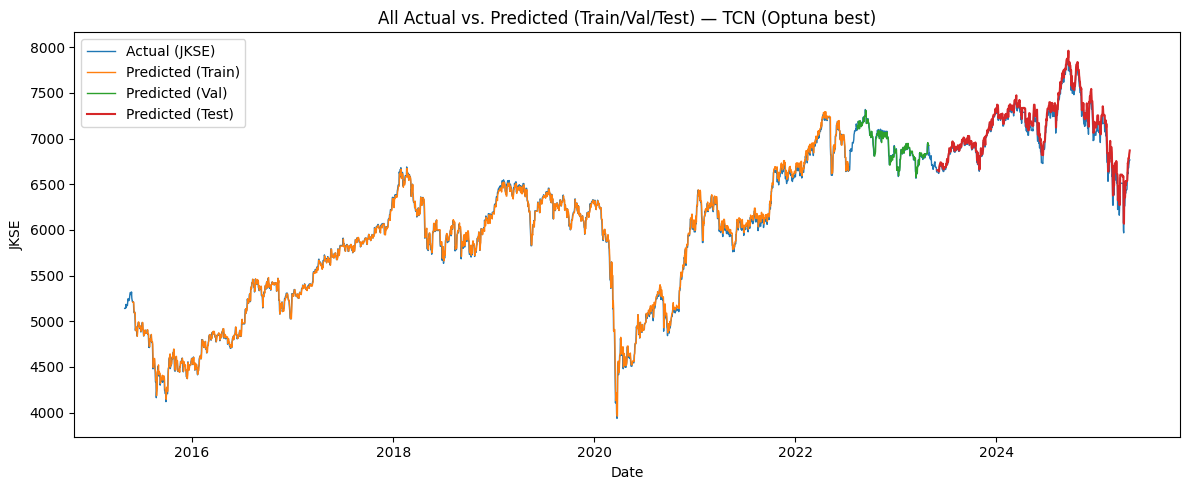

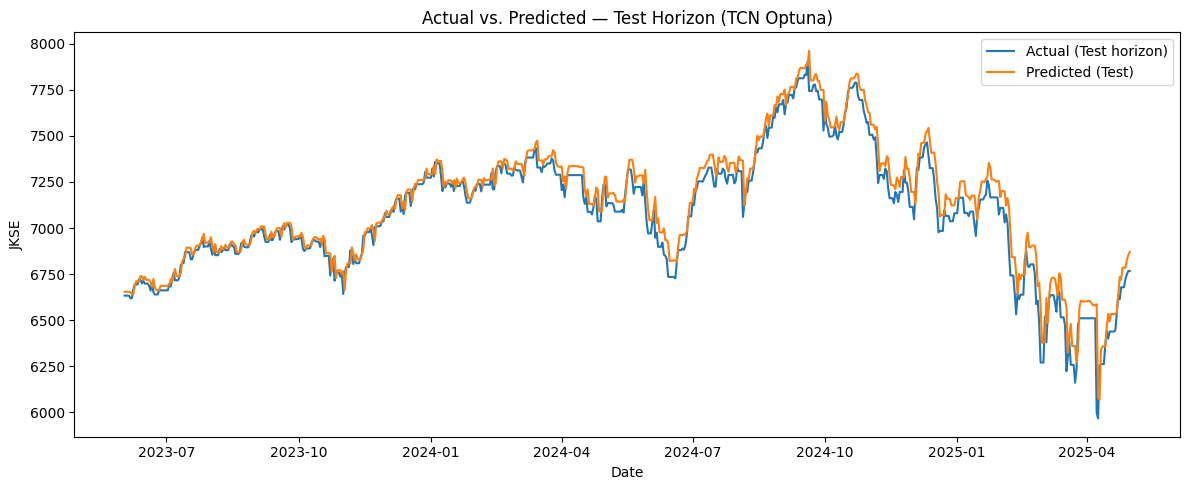

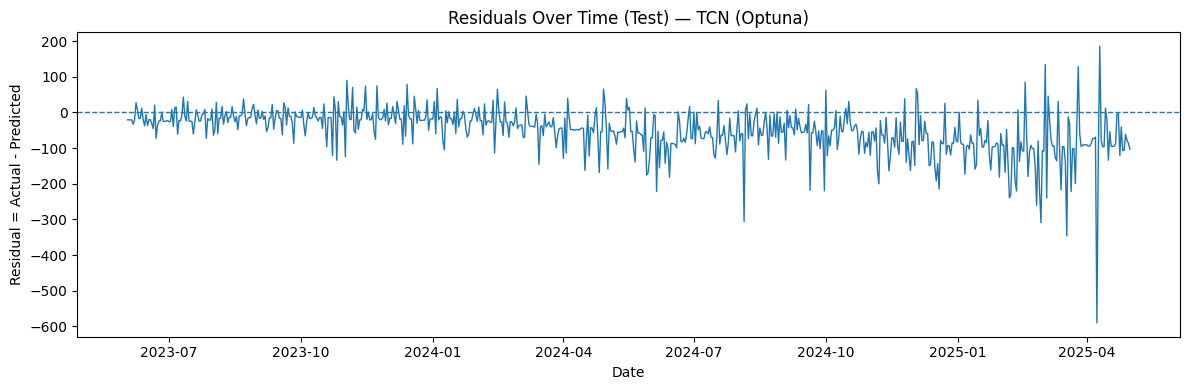

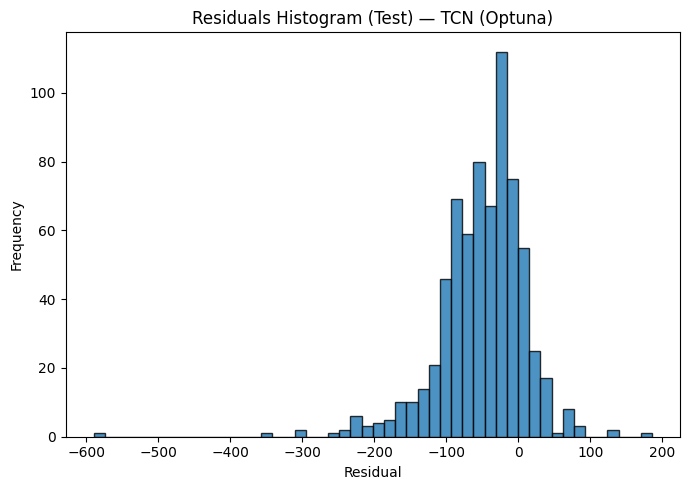

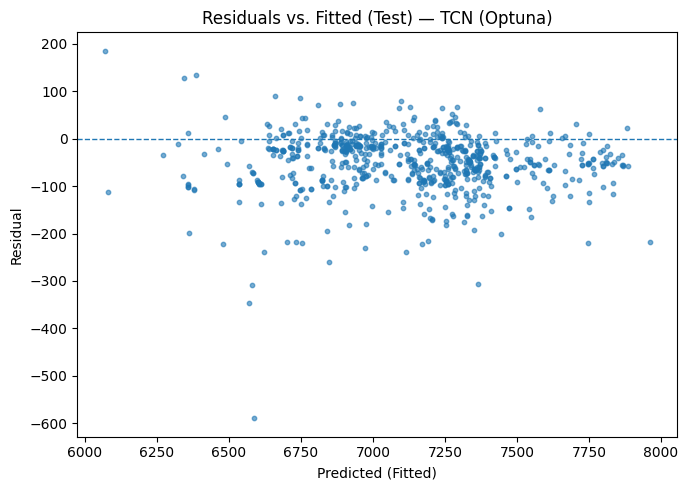

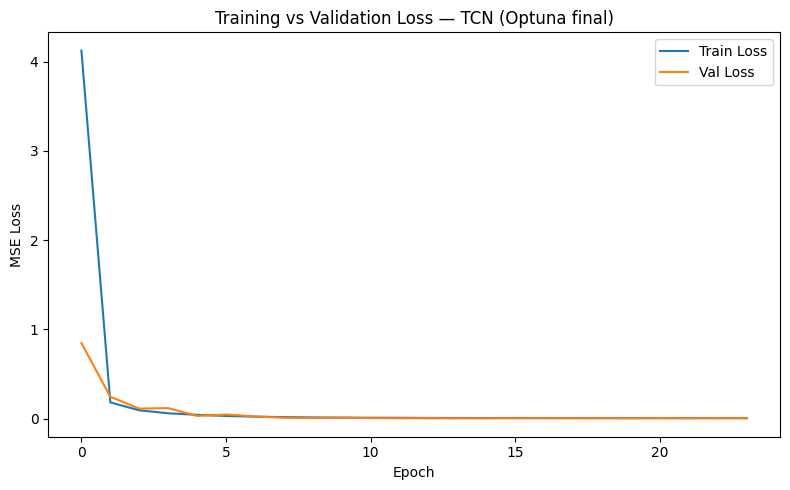

In [21]:
# 1) All actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(actual.index, actual.values, label="Actual (JKSE)", linewidth=1)
plt.plot(pred_train.index, pred_train.values, label="Predicted (Train)", linewidth=1)
plt.plot(pred_val.index,   pred_val.values,   label="Predicted (Val)", linewidth=1)
plt.plot(pred_test.index,  pred_test.values,  label="Predicted (Test)", linewidth=1.5)
plt.title("All Actual vs. Predicted (Train/Val/Test) — TCN (Optuna best)")
plt.xlabel("Date"); plt.ylabel("JKSE")
plt.legend(); plt.tight_layout(); plt.show()

# 2) Actual vs predicted — test horizon
plt.figure(figsize=(12, 5))
plt.plot(actual_test.index, actual_test.values, label="Actual (Test horizon)", linewidth=1.5)
plt.plot(pred_test.index,   pred_test.values,   label="Predicted (Test)", linewidth=1.5)
plt.title("Actual vs. Predicted — Test Horizon (TCN Optuna)")
plt.xlabel("Date"); plt.ylabel("JKSE")
plt.legend(); plt.tight_layout(); plt.show()

# 3) Residuals over time
plt.figure(figsize=(12, 4))
plt.plot(residuals.index, residuals.values, linewidth=1)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Residuals Over Time (Test) — TCN (Optuna)")
plt.xlabel("Date"); plt.ylabel("Residual = Actual - Predicted")
plt.tight_layout(); plt.show()

# 4) Residual histogram
plt.figure(figsize=(7, 5))
plt.hist(residuals.values, bins=50, edgecolor="black", alpha=0.8)
plt.title("Residuals Histogram (Test) — TCN (Optuna)")
plt.xlabel("Residual"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()

# 5) Residuals vs fitted (test)
plt.figure(figsize=(7, 5))
plt.scatter(pred_test.values, residuals.values, s=10, alpha=0.6)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Residuals vs. Fitted (Test) — TCN (Optuna)")
plt.xlabel("Predicted (Fitted)"); plt.ylabel("Residual")
plt.tight_layout(); plt.show()

# 6) Train vs Validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Training vs Validation Loss — TCN (Optuna final)")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
plt.legend(); plt.tight_layout(); plt.show()

In [22]:
# === CONFIGURATION ===
results_dir = os.path.join("..", "Results")
predicted_path = os.path.join(results_dir, "ALL_PREDICTED.csv")
metrics_path = os.path.join(results_dir, "ALL_METRICS.csv")

# Manual model name (since __file__ isn't available in notebooks)
model = "tcn_optuna"
model_name = f"{model}_{RANDOM_SEED}"   # change this for each notebook (e.g., GRU_Baseline)
print("Model Name for Documentation:", model_name)

# Create Results directory if not exists
os.makedirs(results_dir, exist_ok=True)

# ==========================================
# 1️⃣ PREPARE AND ALIGN TESTING DATAFRAME
# ==========================================

# Convert dates
test_dates = test_df.index.to_series().reset_index(drop=True)
actual_values = test_df[TARGET_COL].values

# If ALL_PREDICTED doesn't exist, create the base file
if not os.path.exists(predicted_path):
    print("Creating ALL_PREDICTED.csv ...")
    base_df = pd.DataFrame({
        "date": test_dates,
        "actual": actual_values
    })
    base_df.to_csv(predicted_path, index=False)

# Load and ensure datetime consistency
all_pred_df = pd.read_csv(predicted_path)
all_pred_df["date"] = pd.to_datetime(all_pred_df["date"])

# Ensure the file covers full test range (in case it was made from smaller data)
base_df = pd.DataFrame({
    "date": test_dates,
    "actual": actual_values
})
# Outer merge to make sure we have the full timeline
all_pred_df = pd.merge(base_df, all_pred_df, on=["date", "actual"], how="outer")

# Create new prediction column (aligned to date)
pred_series = pd.Series(pred_test.values, index=pd.to_datetime(idx_test), name=model_name)
pred_series = pred_series.reindex(all_pred_df["date"])  # align by date

# Add or update the model column
all_pred_df[model_name] = pred_series.values

# Sort and save
all_pred_df = all_pred_df.sort_values("date").reset_index(drop=True)
all_pred_df.to_csv(predicted_path, index=False)
print(f"✅ Predictions saved to {predicted_path}")

# ==========================================
# 2️⃣ RECORD METRICS SUMMARY
# ==========================================
metrics_columns = [
    "timestamp",
    "model_name", 
    "seed",
    "mse",
    "mae",
    "rmse", 
    "mape",
    "r2_score",
    "picp",
    "mpiw",
    "winkler_score",
    "training_time_s",
    "testing_time_s", 
    "hpo_trial_s",
    "hpo_time_s"
]

# Create ALL_METRICS if missing
if not os.path.exists(metrics_path):
    print("Creating ALL_METRICS.csv ...")
    pd.DataFrame(columns=metrics_columns).to_csv(metrics_path, index=False)

# Current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Extract metrics
mse, mae, rmse, mape, r2 = metrics_test
picp = mpiw = winkler = 0

# Build metrics row
metrics_row = {
    "timestamp": timestamp,
    "model_name": model_name,
    "seed": RANDOM_SEED,
    "mse": mse,
    "mae": mae,
    "rmse": rmse,
    "mape": mape,
    "r2_score": r2,
    "picp": picp,
    "mpiw": mpiw,
    "winkler_score": winkler,
    "training_time_s": round(end_train - start_train, 4),
    "testing_time_s": round(end_test - start_test, 4),
    "hpo_trial_s": N_TRIALS,
    "hpo_time_s": round(end_opt - start_opt, 4),
}

# Append metrics
all_metrics_df = pd.read_csv(metrics_path)
all_metrics_df = pd.concat([all_metrics_df, pd.DataFrame([metrics_row])], ignore_index=True)
all_metrics_df.to_csv(metrics_path, index=False)
print(f"✅ Metrics appended to {metrics_path}")

print("\n📄 Documentation of predictions and metrics completed successfully.")


Model Name for Documentation: tcn_optuna_271828183
✅ Predictions saved to ..\Results\ALL_PREDICTED.csv
✅ Metrics appended to ..\Results\ALL_METRICS.csv

📄 Documentation of predictions and metrics completed successfully.
